## <font color='blue'>Modelos básicos de aprendizaje</font>

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/ML_2020/master/init.py
import init; init.init(force_download=False); 

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Regresión múltiple (problemas de regresión) y regresión logística (problemas de clasificación)

Vamos a centrarnos por un momento en el problema de regresión. Es casi seguro que para diferentes problemas hayan tenido que utilizar una regresión lineal, polinomial y/o múltiple, con el propósito de encontrar una función que pudiera explicar el comportamiento de un conjunto de datos. Supongamos que queremos modelar un conjunto de datos empleando una función polinomial de la forma:

$$
f({\bf{x}},{\bf{w}} ) = w_0 + w_1 x +  w_2 x^2 + \cdots + w_Mx^M = \sum_{j=0}^{M} w_j x^j
$$

donde $M$ es el orden del polinomio. ¿Cómo se ajusta ${\bf{w}}$?

En este caso particular, la función polinomial que hemos escogido corresponde al <mark>**modelo**</mark> que vamos a usar. Necesitamos entonces definir el criterio por el cual vamos a ajustar los parámetros del modelo, en particular los pesos $w_j$ (El valor de $M$ también requiere ser ajustado, sin embargo si cambiamos $M$ se está cambiando el órden del polinomio y por lo tanto el modelo en sí mismo. Más adelante veremos cómo enfrentar el problema de seleccionar el modelo más adecuado, por ahora supondremos que el valor de $M$ está dado de manera a prior). 

<mark>El criterio (función de costo):</mark>
La función de error más usada es (<b>para un mismo modelo podemos tener diferentes criterios de ajuste</b>):

$$
E({\bf{w}}) = \frac{1}{2N}\sum_{i=1}^{N} \left\lbrace f({\bf{x}}_i, {\bf{w}}) - t_i \right\rbrace^2 
$$

Con esta función de error podemos hallar una $f$ para la cual, la distancia perpendicular de los puntos $x_i$ a $f$ sea mínima.

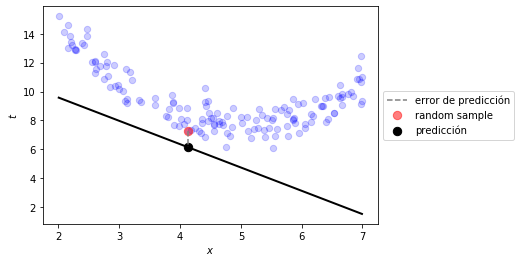

In [9]:
from local.lib.util import plot_model_reg
def linear_prediction(t, x):
    t0,t1 = t
    return t0 + t1*x
t0 = np.random.random()*5+10
t1 = np.random.random()*4-3

plot_model_reg([t0,t1], linear_prediction)

### Ejemplo con datos generados artificialmente:

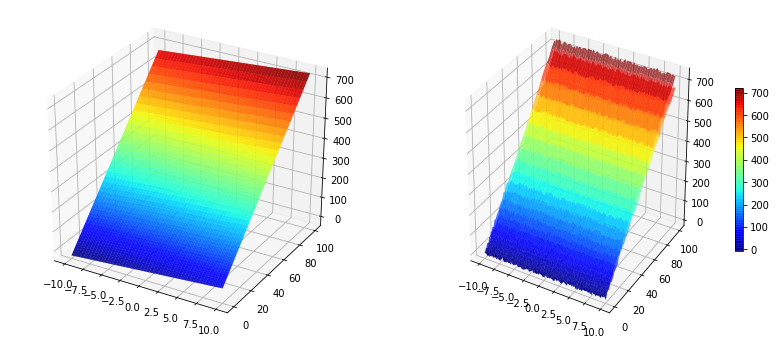

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
Perror = 0.1
fig = plt.figure(figsize=(14,6))
x1 = np.linspace(-10,10,100).reshape(100, 1)
x2 = x1**2

#Polinomio real
y = 3*x1 + 7*x2 - 2
X1, X2 = np.meshgrid(x1, x2)
Y = 3*X1 + 7*X2 - 2

#Asumimos que puede haber ruido en la medición
y2 = y + Perror*np.std(y)*(np.random.rand(100,1) - 0.5)
Y2 = y + Perror*np.std(y)*(np.random.rand(100,100) - 0.5)

#plots
ax = fig.add_subplot(1, 2, 1, projection='3d')
p=ax.plot_surface(X1, X2, Y, rstride=2, cstride=2, cmap=cm.jet, alpha=0.7)
## surface_plot with color grading and color bar
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X1, X2, Y2, rstride=2, cstride=2, cmap=cm.jet, alpha=0.7)
cb = fig.colorbar(p, shrink=0.5)

### <font color='blue'>  Usando una estrategia de alto nivel (caja negra): </font>

In [20]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.c_[x1,x2], y2)

#### ¿Cómo hacemos una predicción?:

In [21]:
reg.predict(np.array([8,5]).reshape(1,-1))

array([[54.70060478]])

#### ¿Y los parámetros del modelo?

In [22]:
print(reg.coef_)
print(reg.intercept_)

[[2.8962397  7.02858355]]
[-3.61223055]


In [23]:
def ECM(w,x,y):
    w = w.reshape(1,-1)
    x = np.c_[x,np.ones((x1.shape[0],1))]
    return np.mean((np.dot(w,x.T).T-y)**2)

ECM(np.c_[reg.coef_,reg.intercept_], np.c_[x1,x2], y2)

37.57463005349896

### <font color='blue'>  Usando una estrategia de nivel intermedio: </font>

Sabemos que el problema que debemos resolver corresponde a un problema de minimización sin restricciones.

In [24]:
from scipy.optimize import minimize
r1 = minimize(lambda w: ECM(w, np.c_[x1,x2], y2), np.random.random(size=3))
r1.x

array([ 2.89623971,  7.02858353, -3.61222993])

In [25]:
ECM(r1.x, np.c_[x1,x2], y2)

37.57463005349924

#### También podemos hacerla predicción:

In [26]:
np.dot(r1.x,np.array([8,5,1]))

54.70060538543853

### <font color='blue'>  Usando una estrategia de más bajo nivel: </font>

Un algoritmo simple que nos permite solucionar el problema de optimización es el <mark>**Algoritmo de Gradiente Descendente**</mark>. Un problema de optimización puede tener múltiples formas o algoritmos para resolverse, cuando el problema de optimización es <b>convexo</b> podemos esperar que casi con cualquier método encontremos el valor del parámetro que hace la función óptima, sin embargo, es posible que el problema de optimización no sea convexo, en cuyo caso el algoritmo o método de optimización juega un rol más importante. También es importante tener en cuenta la velocidad de convergencia del algoritmo o método de optimización, el costo computacional y el número de parámetros libres.

El algoritmo de gradiente descendente consiste en aplicar iterativamente la siguiente regla:

$$
w_j(iter) = w_j(iter-1) - \eta \frac{\partial E({\bf{w}})}{\partial w_j}
$$

donde $\eta$ se conoce como la tasa de aprendizaje.

Si queremos hayar un $\bf{w}$ que minimice el error en el problema de regresión lineal, entonces derivamos la función de error con respecto a cada uno de los parámetros $w_j$:

$$
\frac{\partial E({\bf{w}})}{\partial w_j} = \frac{1}{2N}\sum_{i=1}^{N}\frac{\partial }{\partial w_j}\left( f({\bf{x}}_i,{\bf{w}}) - y_i\right)^2\\
$$

Para efectos de cálculo podemos asumir que el vector $x_i$ contiene todas las características de la muestra $i$ y una característica adicional con valor de 1, que multiplicará al término independiente $w_0$.

$$
\frac{\partial E({\bf{w}})}{\partial w_j} = \frac{1}{N}\sum_{i=1}^{N}\left( f({\bf{x}}_i,{\bf{w}}) - y_i\right) \frac{\partial }{\partial w_j} f({\bf{x}}_i, {\bf{w}})
$$

$$
\frac{\partial E({\bf{w}})}{\partial w_j} = \frac{1}{N}\sum_{i=1}^{N}\left( f({\bf{x}}_i,{\bf{w}}) - y_i\right)x_{ij}
$$

La regla de actualización de los pesos en cada iteración estará entonces dada por:

$$
w_j(iter) = w_j(iter-1) - \frac{\eta}{N} \sum_{i=1}^{N}\left( f({\bf{x}}_i,{\bf{w}}) - y_i\right)x_{ij}
$$

$$
w_j(iter) = w_j(iter-1) - \frac{\eta}{N} \sum_{i=1}^{N}\left( \sum_{k=0}^{d} w_k x_{ik} - y_i\right)x_{ij} 
$$

Si la solución de un problema requiere que sigamos una estrategia de más bajo nivel, entonces se hacen más importantes conceptos de algebra lineal y cálculo, en muchos casos no sólo para comprender los algoritmos, sino también para realizar implementaciones computacionalmente más eficientes.

#### Gradiente descendetente

[[ 2.8962397 ]
 [ 7.02858355]
 [-3.61223055]]


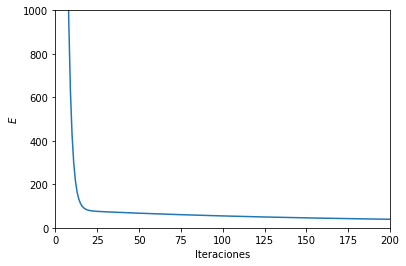

In [27]:
#Inicialización
MaxIter = 1000000
w = np.ones(3).reshape(3, 1)
eta = 0.0001
N = len(x1)
Error =np.zeros(MaxIter)

#Matriz extendida
X = np.array([x1,x2,np.ones((100,1))]).reshape(3, 100);

#Iteraciones
for i in range(MaxIter):
    tem = np.dot(X.T,w)
    tem2 = tem-np.array(y2)
    Error[i] = np.sum(tem2**2)/(2*N)
    tem = np.dot(X,tem2)
    w = w - eta*tem/N
#Gráfica
print(w)
plt.ylim(0,1000)
plt.xlim(0,200)
plt.ion()
plt.plot(np.linspace(0,MaxIter,MaxIter),Error)
plt.xlabel('Iteraciones')
plt.ylabel('$E$')
plt.show()

In [28]:
ECM(w, np.c_[x1,x2], y2)

37.57463005349891

In [31]:
np.dot(w.T,np.array([8,5,1]))

array([54.70060478])

----------------------------------------------------------------------------------------------------------------------------------------------

## <font color='blue'>  Pensemos ahora en el problema de clasificación </font> 

### Regresión logística

Una forma alternativa de entender el problema de clasificación, es buscar una función que sea capaz de dividir el espacio de características y dejar los conjuntos de muestras de cada clase separados.

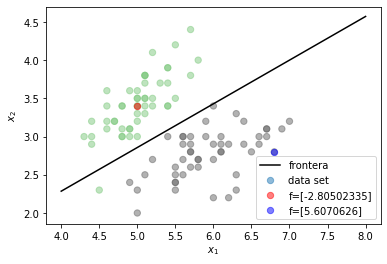

In [11]:
from local.lib.util import plot_frontera
plot_frontera()

Cuando es posible dejar todas las muestras de una clase a un lado de la recta, y las muestras de la otra clase al otro, el problema se conoce como linealmente separable. Sin embargo eso no sucede en la gran mayoría de problemas reales. El problema de clasificación se puede entonces pensar como el problema de encontrar una función polinomial $f$ que pueda dividir los conjuntos de datos de las diferentes clases.

#### Observando la figura anterior:

Si se pudiese encontrar la función dada por la línea negra en la figura anterior, la cual sería de la forma $f({\bf{x}}) = w_1 x_1 + w_2 x_2 + w_0$, se podría utilizar como función de clasificación ya que cualquier muestra evaluada en la función obtendrá como resultado un valor positivo si se ubica a un lado y un valor negativo si se ubica al otro (los valores ubicados justo en la función obtendrían un valor de 0). Teniendo en cuenta que los valores de las etiquetas para el problema de clasificación (las variables a predecir $t_i$), solo pueden tomar dos valores ${0,1}$, entonces una forma simple de usar la función $f$ como clasificador sería asignar las muestras a la clase 1 cuando al ser evaluadas en la función $f$ obtengan una valor positivo y asignar 0 cuando suceda lo contrario.

$$\text{Class} = \left\{
                \begin{array}{ll}
                  1\;\;\;{\rm{if}}\;\;\;w_0  + w_1 x_1  + w_2 x_2  +  \cdots  + w_d x_d  \geq 0\\
                  0\;\;{\rm{\text{other wise}}}
                \end{array}
              \right. $$

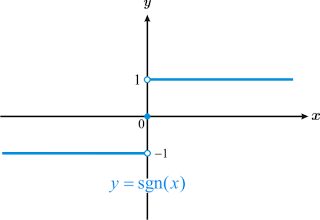

In [15]:
Image("local/imgs/funcionsigno.png", width = 300)

El problema con la función $sgn$ es que es discontinua y no puede ser usada como criterio de optimización para ningún algoritmo basado en gradiente. Un alternativa es utilizar alguna función que tenga una comportamiento asintótico similar pero que sea continua y derivable, por lo que podemos usar la función sigmoide dada por:

$$
g(u) = \frac{\exp(u)}{1 + \exp(u)}
$$

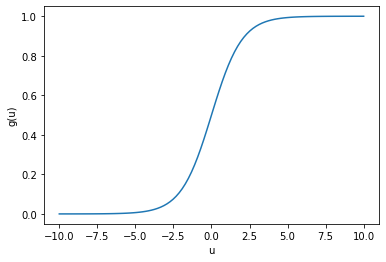

In [19]:
u=np.linspace(-10,10,100)
g = np.exp(u)/(1 + np.exp(u))
plt.plot(u,g)
plt.xlabel('u')
plt.ylabel('g(u)')
plt.show()

El método que utiliza la función sigmoidal para encontrar una frontera de separación polinomial se conoce como <b>Regresión Logística</b>. La función objetivo (criterio de entrenamiento) está dada por:

$$
J({\bf{w}}) = \frac{1}{N} \sum_{i=1}^{N} -t_i \log(g(f({\bf{x}}))) - (1-t_i)\log(1 - g(f({\bf{x}})))
$$

Si se analiza con detenimiento, la función criterio $J$ minimiza el error de clasificación. Es necesario tener en cuenta que dicha función está definida para $t_i$ que toman valores $\left\lbrace 0,1 \right\rbrace$. La ventaja del método de regresión logística es que la función para la actualización de los pesos $\bf{w}$ es muy similar a la función para la regresión lineal. La derivada de $J$ está dada por:

$$
\frac{\partial J({\bf{w}})}{\partial w_j} = \frac{1}{N} \sum_{i=1}^{N}\left( g(f({\bf{x}}_i,{\bf{w}})) - t_i\right)x_{ij}
$$

La única diferencia es la inclusión de la función sigmoidal $g$. Por esa razón podemos usar el mismo algoritmo con solo una pequeña modificación. 

In [12]:
def sigmoide(u):
        g = np.exp(u)/(1 + np.exp(u))
        return g
def Gradiente(X2,y2,MaxIter = 10000, eta = 0.001):
    w = np.ones(3).reshape(3, 1)
    N = len(y2)
    Error =np.zeros(MaxIter)
    Xent = np.concatenate((X2,np.ones((100,1))),axis=1)

    for i in range(MaxIter):
        tem = np.dot(Xent,w)
        tem2 = sigmoide(tem.T)-np.array(y2)
        Error[i] = np.sum(abs(tem2))/N
        tem = np.dot(Xent.T,tem2.T)
        wsig = w - eta*tem/N
        w = wsig
    return w, Error

<IPython.core.display.Javascript object>


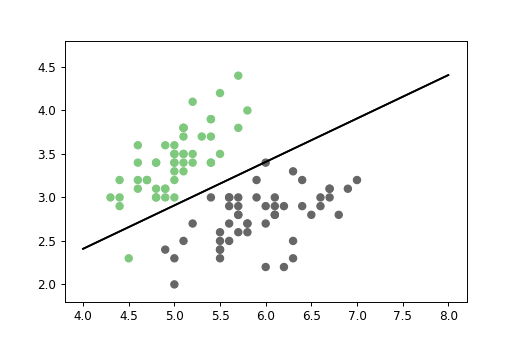

In [14]:
%matplotlib notebook
from sklearn import datasets
import time
fig, ax = plt.subplots(1,1)
iris = datasets.load_iris()
X, y = iris.data, iris.target
X2 = X[:100][:,:2]
y2 = y[:100]
ax.scatter(X2[:,0], X2[:,1], c=y2,cmap="Accent");
w,_ = Gradiente(X2,y2,MaxIter = 1)
x1 = np.linspace(4,8,20)
x2 = -(w[0]/w[1])*x1 - (w[2]/w[1])
line1, = ax.plot(x1,x2,'k')

for i in range(1,10000,100):
    w,_ = Gradiente(X2,y2,MaxIter = i)
    x2 = -(w[0]/w[1])*x1 - (w[2]/w[1])
    line1.set_ydata(x2)
    if i > 1000:
        ax.set_ylim([1.8,4.8])
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(.300)
line1, = ax.plot(x1,x2,'k')

#### Veamos el mismo proceso en el espacio de búsqueda

In [15]:
import itertools
def n_grad(X2,t,w):
    N = X2.shape[0]
    Xent = np.concatenate((X2,np.ones((X2.shape[0],1))),axis=1)
    return 2*Xent.T.dot(sigmoide(Xent.dot(w))-t)/N

def cross_entropy(X2,t,w):
    epsilon=1e-12
    Xent = np.concatenate((X2,np.ones((X2.shape[0],1))),axis=1)
    predictions = np.clip(sigmoide(np.dot(Xent,w.T)), epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -(np.sum(t*np.log(predictions+1e-9))+np.sum((1-t)*np.log(1-predictions)))/N
    return ce

def plot_cost(cost, t0_range, t1_range, vx=None,vy=None, vz=None):
    k0,k1 = 60,60

    t0 = np.linspace(t0_range[0], t0_range[1], k0)
    t1 = np.linspace(t1_range[0], t1_range[1], k1)

    p = np.zeros((k0,k1))

    for i,j in itertools.product(range(k0), range(k1)):
        p[i,j] = np.log(cost(np.r_[t0[i],t1[j], vz]))

    plt.contourf(t0, t1, p.T, cmap=plt.cm.hot, levels=np.linspace(np.min(p), np.max(p), 20))
    plt.ylabel(r"$w_2$")
    plt.xlabel(r"$w_1$")
    plt.title("loss")
    plt.colorbar()

    if vx is not None:
        plt.axvline(vx, color="white")
    if vy is not None:
        plt.axhline(vy, color="white")

In [16]:
from scipy.optimize import minimize
g = []
loss_history = []
def log(xk):
    loss_history.append(loss(xk))
    g.append(xk)
#Estoy graficando una función de tres variables pero sólo dos de los ejes, debo garantizar la misma región del espacio
init_t = np.ones(3)#np.random.random(size=3)

loss = lambda t: cross_entropy(X2,y2,t)
r = minimize(loss, init_t, callback=log, method="BFGS")

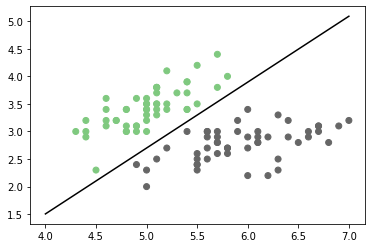

In [17]:
%matplotlib inline
x1 = np.linspace(4,7,20)
fig, ax = plt.subplots(1,1)
ax.scatter(X2[:,0], X2[:,1], c=y2,cmap="Accent");
x2 = -(r.x[0]/r.x[1])*x1 - (r.x[2]/r.x[1])
line1, = ax.plot(x1,x2,'k')

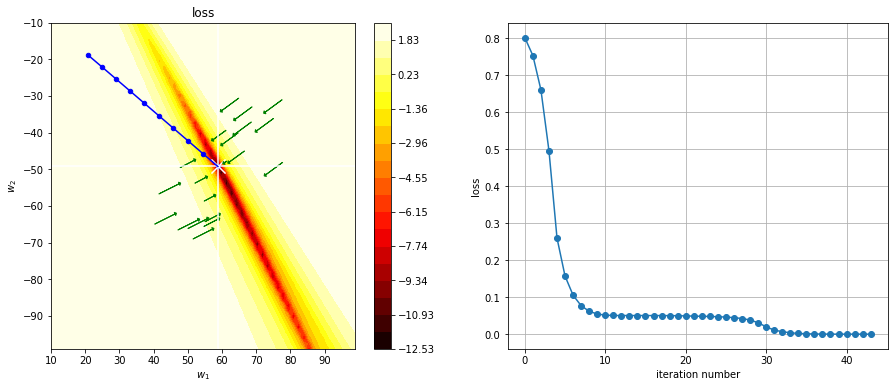

In [14]:
%matplotlib inline
plt.figure(figsize=(15,6))
plt.subplot(121)
plot_cost(loss, (10,99), (-10,-99), vx=r.x[0], vy=r.x[1], vz=r.x[2])
g = np.r_[g]
plt.plot(g[-10:,0], g[-10:,1], color="blue")
plt.scatter(g[-10:,0], g[-10:,1], color="blue", s=20)
plt.scatter(g[-1,0], g[-1,1], marker="x", color="white", s=200)

# plot gradient at some points
for _ in range(10):
    t = np.random.random()*20+r.x[0], np.random.random()*20+r.x[1], r.x[2]
    grad = n_grad(X2,y2,t)
    plt.arrow(t[0], t[1], -grad[0], -grad[1], head_width=1, head_length=0.5, fc='green', ec='green')
for _ in range(10):
    t = -np.random.random()*20+r.x[0], -np.random.random()*20+r.x[1], r.x[2]
    grad = n_grad(X2,y2,t)
    plt.arrow(t[0], t[1], -grad[0], -grad[1], head_width=1, head_length=0.5, fc='green', ec='green')

plt.subplot(122)
plt.plot(loss_history, marker="o")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.grid()

### zoom al óptimo

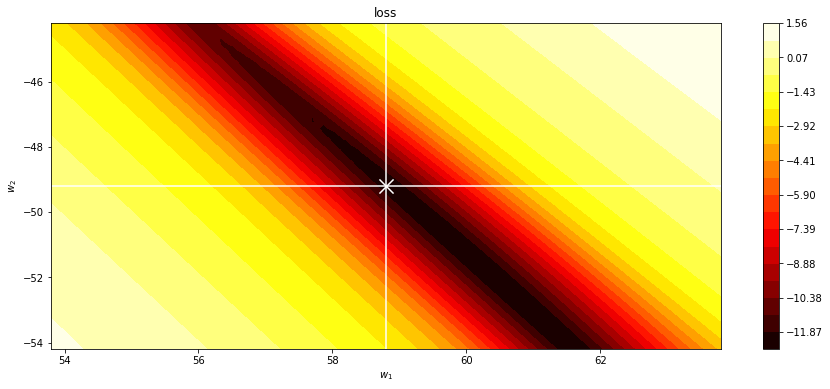

In [15]:
%matplotlib inline
plt.figure(figsize=(15,6))
plot_cost(loss, (r.x[0]-5,r.x[0]+5), (r.x[1]-5,r.x[1]+5), vx=r.x[0], vy=r.x[1], vz=r.x[2])
plt.scatter(g[-1,0], g[-1,1], marker="x", color="white", s=200)

#### Veamos el efecto del número de iteraciones y de la tasa de aprendizaje:

In [18]:
%matplotlib inline

def GradientSigmo(MaxIter=10000, eta = 0.001):
    plt.clf()
    plt.figure(figsize=(30,10))
    plt.axis([None, None, 0, 100])
    iris = datasets.load_iris()
    X, y = iris.data, iris.target
    X2 = X[:100][:,:2]
    y2 = y[:100]
    #Aprendizaje
    w = np.ones(3).reshape(3, 1)
    N = len(y2)
    Error =np.zeros(MaxIter)
    Xent = np.concatenate((X2,np.ones((100,1))),axis=1)

    for i in range(MaxIter):
        tem = np.dot(Xent,w)
        tem2 = sigmoide(tem.T)-np.array(y2)
        Error[i] = np.sum(np.abs(tem2))/N
        tem = np.dot(Xent.T,tem2.T)
        wsig = w - eta*tem/N
        w = wsig


    print(w)
    print('Error=',Error[-1])
    #Grafica de la frontera encontrada
    plt.subplot(1,2,2)
    iris = datasets.load_iris()
    X, y = iris.data, iris.target
    X2 = X[:100][:,:2]
    y2 = y[:100]
    plt.scatter(X2[:,0], X2[:,1], c=y2,cmap="Accent");
    x1 = np.linspace(4,8,20)
    x2 = -(w[0]/w[1])*x1 - (w[2]/w[1])
    
    plt.plot(x1,x2)
    plt.show()
    print(MaxIter,eta)


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(GradientSigmo,MaxIter=[1,10,100,1000,10000], eta=[0.0001,0.001,0.1,1,10]);    
    

interactive(children=(Dropdown(description='MaxIter', index=4, options=(1, 10, 100, 1000, 10000), value=10000)…

#### Bibliografy